In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset, Subset, random_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
from sklearn.preprocessing import label_binarize

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
data_directory = "../data/dataset_blood_group/"
image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [5]:
dataset = datasets.ImageFolder(root=data_directory, transform=image_transform)
class_counts = Counter([label for _, label in dataset])
class_labels = dataset.classes

In [6]:
print("Class Distribution:")
for class_id, count in class_counts.items():
    print(f"{class_labels[class_id]}: {count}")

Class Distribution:
A+: 565
A-: 1009
AB+: 708
AB-: 761
B+: 652
B-: 741
O+: 852
O-: 712


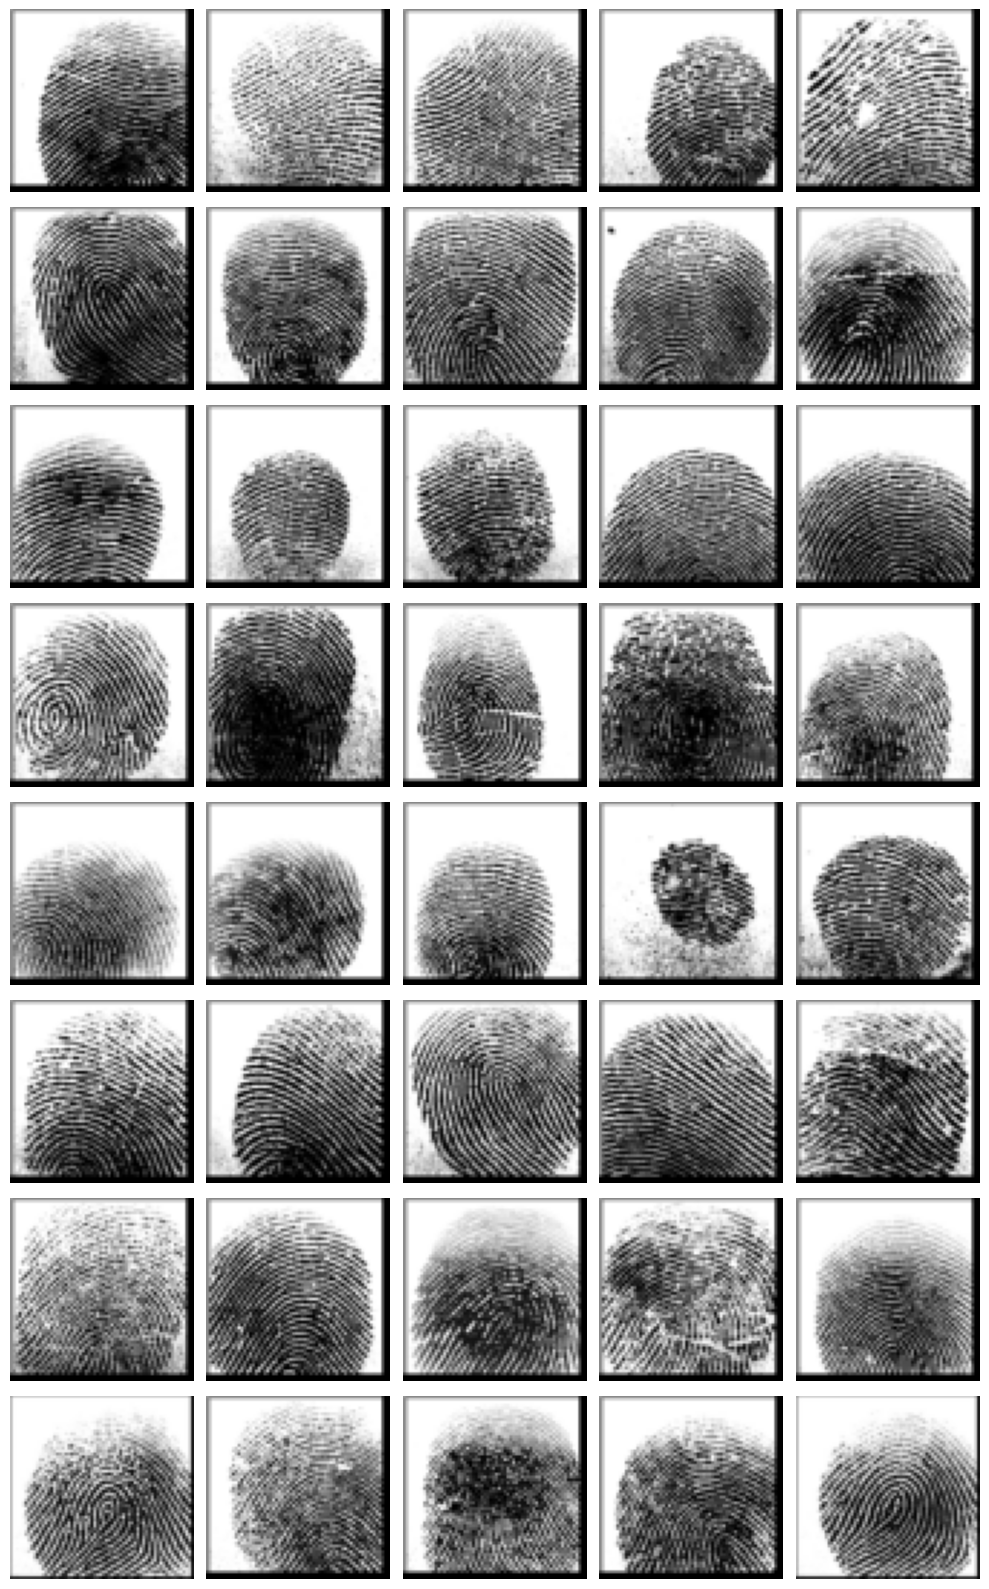

In [7]:
fig, axes = plt.subplots(len(class_labels), 5, figsize=(10, len(class_labels) * 2))
for class_id in range(len(class_labels)):
    class_images = [image for image, label in dataset if label == class_id][:5]
    for i, image in enumerate(class_images):
        axes[class_id, i].imshow(image.permute(1, 2, 0).numpy() * 0.5 + 0.5)
        axes[class_id, i].axis("off")
    axes[class_id, 0].set_ylabel(class_labels[class_id], fontsize=12)
plt.tight_layout()
sns.despine()
plt.show()

C:\Users\anony\AppData\Local\Temp\ipykernel_6192\1704754898.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="coolwarm")


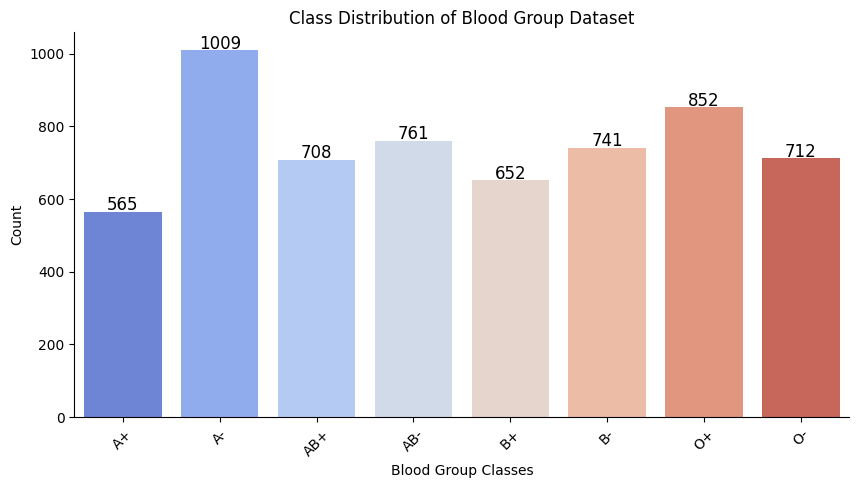

In [8]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="coolwarm")
plt.xticks(ticks=range(len(class_labels)), labels=class_labels, rotation=45)
plt.xlabel("Blood Group Classes")
plt.ylabel("Count")
plt.title("Class Distribution of Blood Group Dataset")
for i, count in enumerate(class_counts.values()):
    plt.text(i, count + 5, str(count), ha='center', fontsize=12)
sns.despine()
plt.show()

In [10]:
max_count = max(class_counts.values())
balanced_data = []
for class_id, count in class_counts.items():
    class_samples = [sample for sample in dataset if sample[1] == class_id]
    oversampled = class_samples * (max_count // count) + class_samples[: max_count % count]
    balanced_data.extend(oversampled)

balanced_dataset = [(image, label) for image, label in balanced_data]
balanced_class_counts = Counter([label for _, label in balanced_dataset])

C:\Users\anony\AppData\Local\Temp\ipykernel_6192\272741918.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(balanced_class_counts.keys()), y=list(balanced_class_counts.values()), palette="coolwarm")


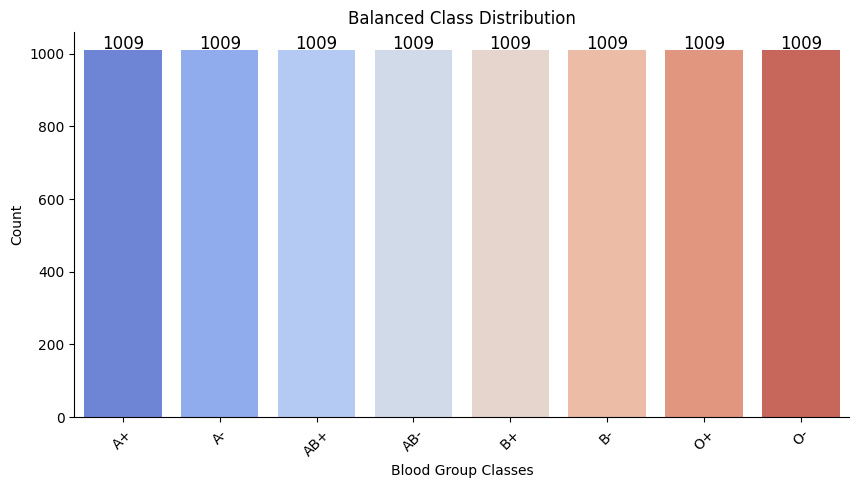

In [11]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(balanced_class_counts.keys()), y=list(balanced_class_counts.values()), palette="coolwarm")
plt.xticks(ticks=range(len(class_labels)), labels=class_labels, rotation=45)
plt.xlabel("Blood Group Classes")
plt.ylabel("Count")
plt.title("Balanced Class Distribution")
for i, count in enumerate(balanced_class_counts.values()):
    plt.text(i, count + 5, str(count), ha='center', fontsize=12)
sns.despine()
plt.show()

In [13]:
total_size = len(balanced_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(balanced_dataset, [train_size, val_size, test_size])

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 5650
Validation set size: 1614
Test set size: 808


In [18]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [34]:
class BloodGroupCNN(nn.Module):
    def __init__(self, num_classes):
        super(BloodGroupCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

num_classes = len(class_labels)
model = BloodGroupCNN(num_classes).to(device)


In [35]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_loss = float('inf')
patience, counter = 5, 0

In [36]:
for epoch in range(epochs):
    model.train()
    correct, total, train_loss = 0, 0, 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)
    
    model.eval()
    correct, total, val_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)
    
    scheduler.step(val_losses[-1])
    
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f} - Train Acc: {train_accuracies[-1]:.2f}% - Val Loss: {val_losses[-1]:.4f} - Val Acc: {val_accuracies[-1]:.2f}%")
    
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break


Epoch 1/50 - Train Loss: 1.7877 - Train Acc: 31.75% - Val Loss: 1.3401 - Val Acc: 63.63%
Epoch 2/50 - Train Loss: 1.0685 - Train Acc: 72.96% - Val Loss: 0.9180 - Val Acc: 82.22%
Epoch 3/50 - Train Loss: 0.9165 - Train Acc: 80.27% - Val Loss: 0.8842 - Val Acc: 83.21%
Epoch 4/50 - Train Loss: 0.8765 - Train Acc: 81.59% - Val Loss: 0.8464 - Val Acc: 81.41%
Epoch 5/50 - Train Loss: 0.8416 - Train Acc: 84.35% - Val Loss: 0.7997 - Val Acc: 84.76%
Epoch 6/50 - Train Loss: 0.8250 - Train Acc: 83.89% - Val Loss: 0.7570 - Val Acc: 88.04%
Epoch 7/50 - Train Loss: 0.8113 - Train Acc: 85.50% - Val Loss: 0.8052 - Val Acc: 85.38%
Epoch 8/50 - Train Loss: 0.7894 - Train Acc: 86.34% - Val Loss: 0.7302 - Val Acc: 89.34%
Epoch 9/50 - Train Loss: 0.7923 - Train Acc: 85.96% - Val Loss: 0.7563 - Val Acc: 85.56%
Epoch 10/50 - Train Loss: 0.7783 - Train Acc: 86.51% - Val Loss: 0.7390 - Val Acc: 87.67%
Epoch 11/50 - Train Loss: 0.7773 - Train Acc: 86.94% - Val Loss: 0.7229 - Val Acc: 88.04%
Epoch 12/50 - Train

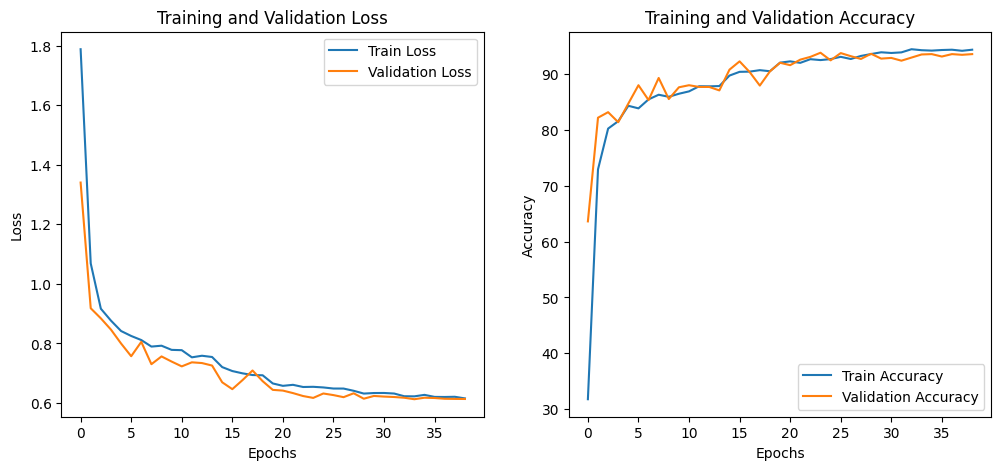

In [37]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [40]:
model.eval()
correct, total = 0, 0
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Test Accuracy: 93.69%
Classification Report:
              precision    recall  f1-score   support

          A+       0.97      0.94      0.96       125
          A-       0.99      0.84      0.91       100
         AB+       0.97      0.98      0.97        91
         AB-       0.81      0.96      0.88        96
          B+       0.97      0.93      0.95       120
          B-       0.98      0.96      0.97       101
          O+       0.96      0.95      0.96        84
          O-       0.86      0.96      0.91        91

    accuracy                           0.94       808
   macro avg       0.94      0.94      0.94       808
weighted avg       0.94      0.94      0.94       808



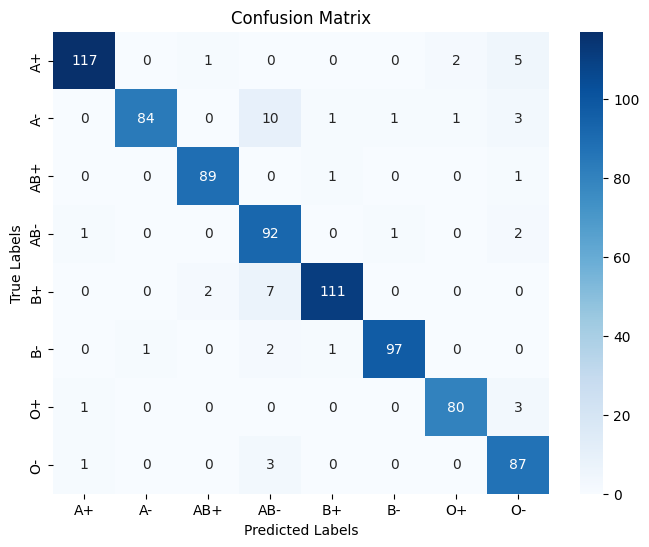

In [42]:
model.eval()
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

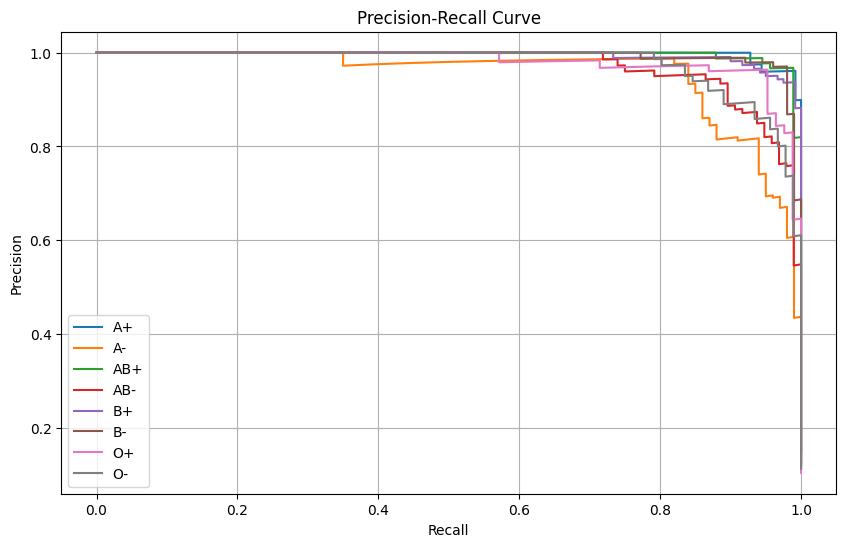

In [47]:
model.eval()
y_true, y_scores = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_scores.extend(probabilities.cpu().numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)

plt.figure(figsize=(10, 6))
for i, class_name in enumerate(class_labels):
    precision, recall, _ = precision_recall_curve(y_true == i, y_scores[:, i])
    plt.plot(recall, precision, label=f"{class_name}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

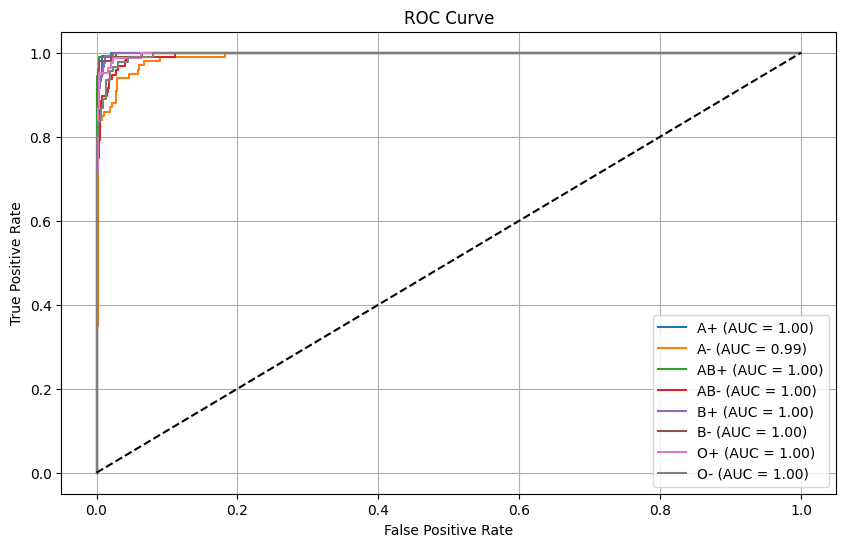

In [48]:
plt.figure(figsize=(10, 6))
for i, class_name in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_true == i, y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

In [49]:
torch.save(model.state_dict(), "blood_group_model.pth")

In [80]:
from PIL import Image

def predict_single_image(model, image_path, transform, class_labels):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return class_labels[predicted.item()]

image_path = "../data/test_set/AB-/6670_411.jpg"
prediction = predict_single_image(model, image_path, image_transform, class_labels)
print(f"Predicted Blood Group: {prediction}")

Predicted Blood Group: AB-


Predicted Blood Group: O-


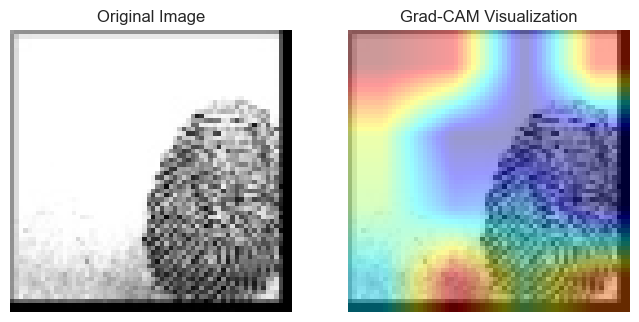

In [82]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

class BloodGroupCNN(nn.Module):
    def __init__(self, num_classes):
        super(BloodGroupCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_labels = ["A+", "A-", "AB+", "AB-", "B+", "B-", "O+", "O-"]

model = BloodGroupCNN(len(class_labels)).to(device)
model.load_state_dict(torch.load("blood_group_model.pth", map_location=device))
model.eval()

image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def predict_single_image(model, image_path, transform, class_labels):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    
    return class_labels[predicted.item()], image_tensor, predicted.item()

def get_grad_cam(model, image_tensor, class_idx):
    gradients = None
    activations = None
    
    def hook_grad(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]
    
    def hook_activation(module, inp, out):
        nonlocal activations
        activations = out
    
    target_layer = model.conv_layers[-6]
    target_layer.register_forward_hook(hook_activation)
    target_layer.register_backward_hook(hook_grad)
    
    model.zero_grad()
    output = model(image_tensor)
    class_score = output[0, class_idx]
    class_score.backward()
    
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = activations.squeeze().detach()
    
    for i in range(activations.shape[0]):
        activations[i, :, :] *= pooled_gradients[i]
    
    heatmap = torch.mean(activations, dim=0).cpu().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    return heatmap

def overlay_heatmap(image_path, heatmap):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (64, 64))
    heatmap = cv2.resize(heatmap, (64, 64))
    
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    superimposed_image = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)
    
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Original Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Grad-CAM Visualization")
    
    plt.show()

image_path = "../data/test_set/O-/1858_334.jpg"
predicted_label, image_tensor, class_idx = predict_single_image(model, image_path, image_transform, class_labels)
print(f"Predicted Blood Group: {predicted_label}")

heatmap = get_grad_cam(model, image_tensor, class_idx)
overlay_heatmap(image_path, heatmap)


Predicted Blood Group: AB-


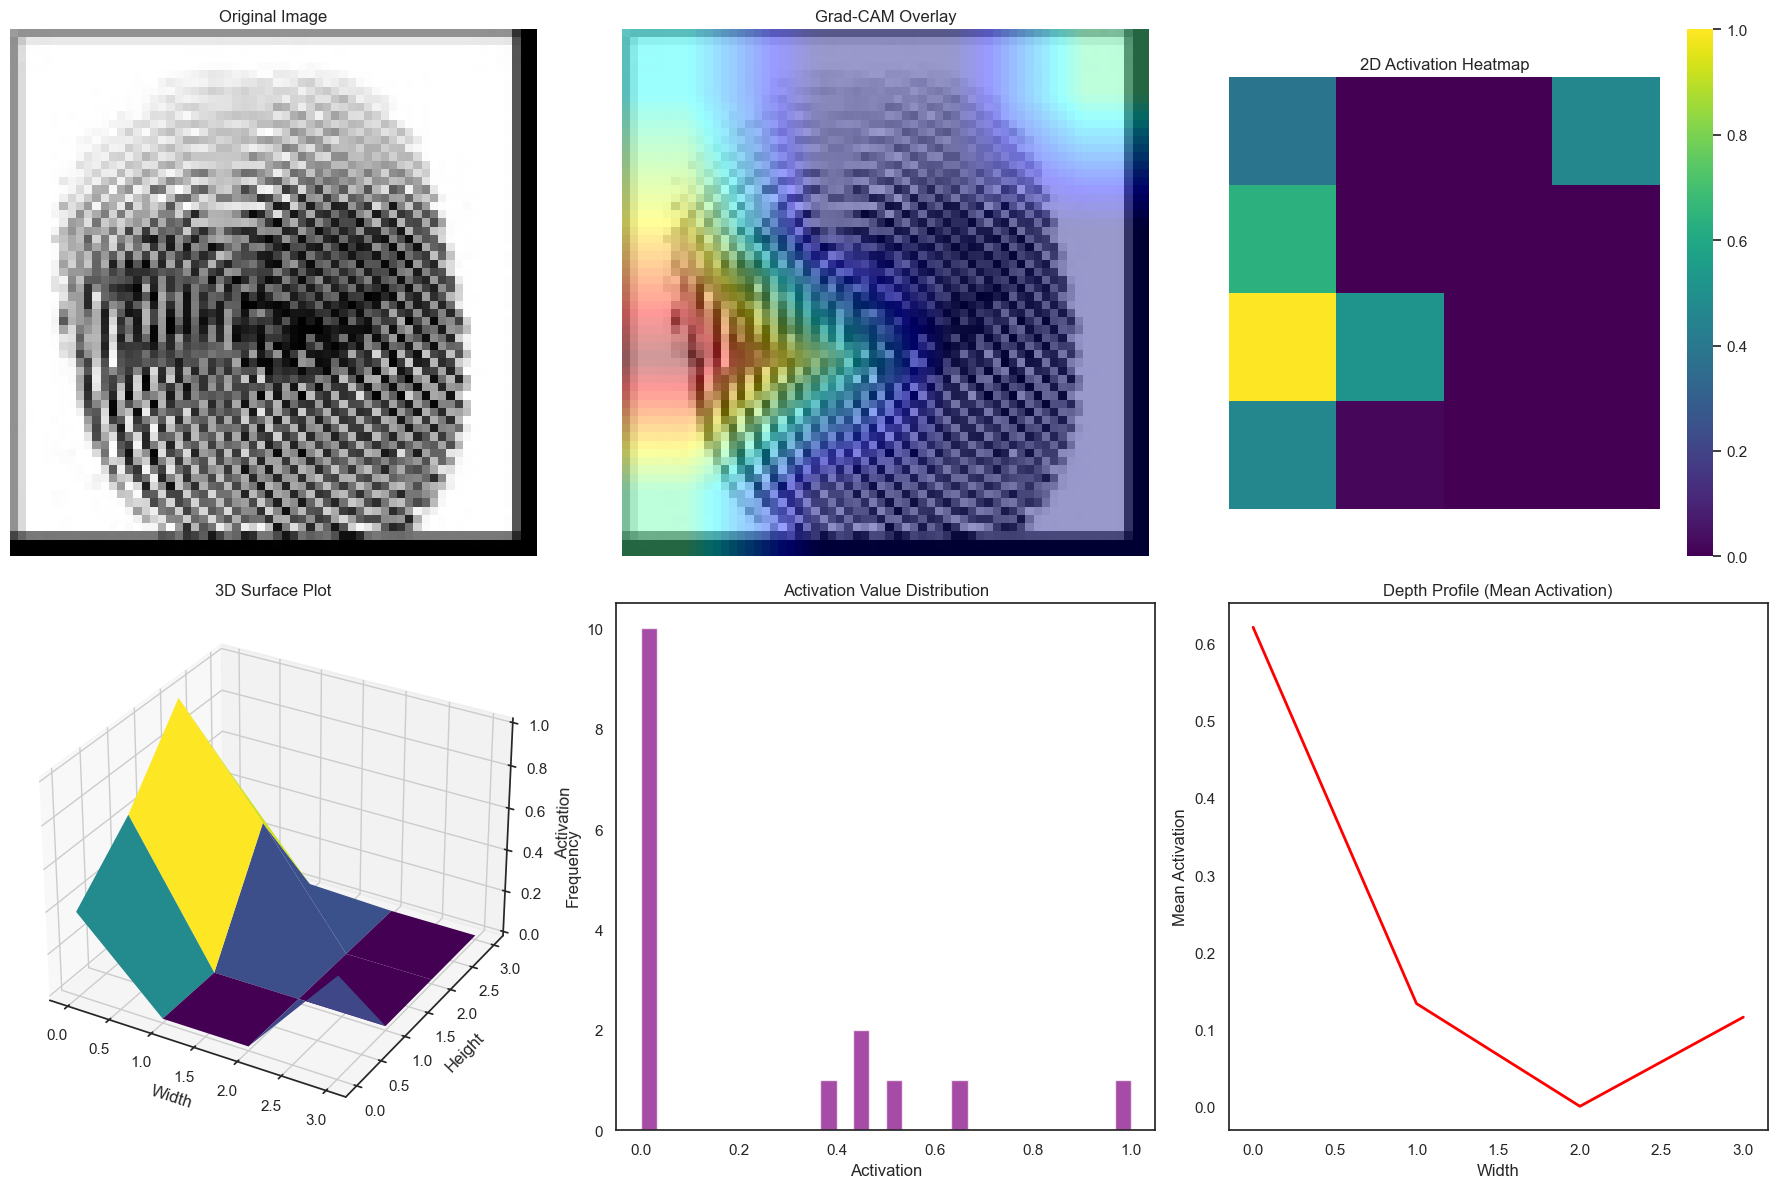

In [78]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

class BloodGroupCNN(nn.Module):
    def __init__(self, num_classes):
        super(BloodGroupCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.4),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.4),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.4),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.5)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_labels = ["A+", "A-", "AB+", "AB-", "B+", "B-", "O+", "O-"]

model = BloodGroupCNN(len(class_labels)).to(device)
model.load_state_dict(torch.load("blood_group_model.pth", map_location=device))
model.eval()

image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def predict_single_image(model, image_path, transform, class_labels):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    return class_labels[predicted.item()], image_tensor, predicted.item()

def get_grad_cam(model, image_tensor, class_idx):
    gradients = None
    activations = None
    def hook_grad(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]
    def hook_activation(module, inp, out):
        nonlocal activations
        activations = out
    target_layer = model.conv_layers[-6]
    target_layer.register_forward_hook(hook_activation)
    target_layer.register_backward_hook(hook_grad)
    model.zero_grad()
    output = model(image_tensor)
    class_score = output[0, class_idx]
    class_score.backward()
    pooled_gradients = torch.mean(gradients, dim=[0,2,3])
    activations = activations.squeeze().detach()
    for i in range(activations.shape[0]):
        activations[i, :, :] *= pooled_gradients[i]
    heatmap = torch.mean(activations, dim=0).cpu().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

def advanced_xai_plots(image_path, heatmap):
    image = cv2.imread(image_path)
    image_resized = cv2.resize(image, (64, 64))
    heatmap_resized = cv2.resize(heatmap, (64, 64))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(image_resized, 0.6, heatmap_color, 0.4, 0)
    aggregated_activation = np.mean(heatmap, axis=0)
    
    fig = plt.figure(figsize=(18, 12))
    
    ax1 = fig.add_subplot(2, 3, 1)
    ax1.imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))
    ax1.set_title("Original Image")
    ax1.axis('off')
    
    ax2 = fig.add_subplot(2, 3, 2)
    ax2.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    ax2.set_title("Grad-CAM Overlay")
    ax2.axis('off')
    
    ax3 = fig.add_subplot(2, 3, 3)
    sns.heatmap(heatmap, cmap="viridis", cbar=True, ax=ax3, square=True, xticklabels=False, yticklabels=False)
    ax3.set_title("2D Activation Heatmap")
    
    ax4 = fig.add_subplot(2, 3, 4, projection='3d')
    X, Y = np.meshgrid(np.arange(heatmap.shape[1]), np.arange(heatmap.shape[0]))
    ax4.plot_surface(X, Y, heatmap, cmap="viridis", edgecolor='none')
    ax4.set_title("3D Surface Plot")
    ax4.set_xlabel("Width")
    ax4.set_ylabel("Height")
    ax4.set_zlabel("Activation")
    
    ax5 = fig.add_subplot(2, 3, 5)
    ax5.hist(heatmap.ravel(), bins=30, color='purple', alpha=0.7)
    ax5.set_title("Activation Value Distribution")
    ax5.set_xlabel("Activation")
    ax5.set_ylabel("Frequency")
    
    ax6 = fig.add_subplot(2, 3, 6)
    ax6.plot(aggregated_activation, color='red', linewidth=2)
    ax6.set_title("Depth Profile (Mean Activation)")
    ax6.set_xlabel("Width")
    ax6.set_ylabel("Mean Activation")
    
    plt.tight_layout()
    plt.show()

image_path = "../data/split/test/A-/3b7a_453.jpg"
predicted_label, image_tensor, class_idx = predict_single_image(model, image_path, image_transform, class_labels)
print("Predicted Blood Group:", predicted_label)
heatmap = get_grad_cam(model, image_tensor, class_idx)
advanced_xai_plots(image_path, heatmap)


In [71]:
# its the best!!!